**Bonus Question 3**
Student : Arora, Sanjana (V00966221)

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**The below mentioned codes are repeated from solution for question 2 untill futher text**

Please upload the election_clean file as provided in zipped folder

In [109]:
df = pd.read_csv('elections_clean.csv')

In [110]:
df.columns

Index(['Unnamed: 0', 'votes', 'UnemploymentRate2015', 'MedHHInc2014',
       'PerCapitaInc', 'PovertyAllAgesPct2014', 'Deep_Pov_All', 'Population',
       'Area in square miles - Total area', 'PopDensity', 'TOT_MALE_rate',
       'TOT_FEMALE_rate', 'voter_turnout_rate', 'Democrat', 'State', 'County',
       'Education', 'Religion', 'Old', 'Young', 'Adult', 'EthnicMale',
       'EthnicFemale'],
      dtype='object')

In [111]:
subset = df[['Education', 'Religion', 'EthnicMale', 'EthnicFemale', 'Democrat']].copy()

In [112]:
subset.columns

Index(['Education', 'Religion', 'EthnicMale', 'EthnicFemale', 'Democrat'], dtype='object')

In [113]:
subset.head()

,Education,Religion,EthnicMale,EthnicFemale,Democrat
0,OnlyDiploma,Other Misc,WHITE_MALE_rate,WHITE_FEMALE_rate,0
1,OnlyDiploma,Catholic,WHITE_MALE_rate,WHITE_FEMALE_rate,0
2,College,Christian Generic,WHITE_MALE_rate,WHITE_FEMALE_rate,0
3,OnlyDiploma,Catholic,WHITE_MALE_rate,WHITE_FEMALE_rate,0
4,College,Catholic,WHITE_MALE_rate,WHITE_FEMALE_rate,0


In [114]:
#Calculating the entropy

def entropy(Y): # Y is the Target Columns
  values, counts = np.unique(Y,return_counts = True)
  for i in range(len(values)):
    prob = counts[i]/np.sum(counts) # calculating the probability
    h = np.sum(-(prob)*np.log2(prob))
  return h

In [115]:
#Calculating the Information Gain
def InfoGain(dataset,split_feature_name, Y):
  total_h = entropy(dataset[Y]) 
  values, counts = np.unique(dataset[split_feature_name],return_counts = True)
  weighted_h = 0
  for i in range(len(values)):
    prob = counts[i]/np.sum(counts)
    feature = dataset.where(dataset[split_feature_name]==values[i]).dropna()[Y]
    h = entropy(feature)
    weighted_h = weighted_h + prob*h
  IG = total_h - weighted_h
  return IG

In [116]:
def DecisionClassifier(dataset,originaldata,features,Y,depth=20,filter_node_class = None,height=-1, length=[], feat=[]):
      
      #Storing and Adding the length of the tree
      height=height
      length.append(height)
      
      # Checking if all target values have same values left
      if (len(np.unique(dataset[Y])) <= 1):
          
          return np.unique(dataset[Y])[0], length, feat # return the value and length of the tree
      
      # if dataset has got empty
      elif (len(dataset)==0 or height==depth) :
        
        # index of the mode target feature value in dataset
        index = np.argmax(np.unique(originaldata[Y],return_counts=True)[1])
        mode = np.unique(originaldata[Y])[index]
        return mode, length,feat #returning the target feature value occuring maximum number of times in original dataset
      
      # if the number of features have got zero, returning the mode target feature value indicated by the parent node that called the DecisionClassifier recursion
      elif (len(features) ==0):
        return filter_node_class, length,feat
      
      
      # if none of the conditions are true, growing the tree
      else:
        
        # growing the tree
        # assigning parent node class feature values as the selected target feature value having max. no. of occurrences
          index = np.argmax(np.unique(dataset[Y],return_counts=True)[1])
          filter_node_class  = np.unique(dataset[Y])[index]
          
         # selecting the feature which best splits the dataset 
          item_vals = [InfoGain(dataset,feature,Y) for feature in features]
          
          # best feature is the feature having maximum information gain about the target feature
          best_featureindex = np.argmax(item_vals)
          best_feature = features[best_featureindex]
         
          # tree structure
          tree = {best_feature:{}}
          feat.append(best_feature)
          # iterating over all features except for the best feature
          features = [i for i in features if i != best_feature]
        # Adding the height as a feature is getting added to the decision stump
          height+= 1
          
        
          
            #finding the dataset corresponding the best feature for further analysis
          for vals in np.unique(dataset[best_feature]):
              
              sub_data = dataset.where(dataset[best_feature] == vals).dropna()  
              subtree, length, feat = DecisionClassifier(sub_data,dataset,features,Y,depth,filter_node_class,height=height, length=length,feat=feat)
            
            
            # adding subtree, under the grown tree
              tree[best_feature][vals] = subtree
          return tree, length, feat 

In [117]:
def prediction(query,tree,default = 1):
    for key in list(query.keys()):
        #check for every key in the query, if the feature exists in the keys of the tree
        if key in list(tree.keys()):
            
            try:
                result = tree[key][query[key]] 
            except:
              #if the feature does not exist return default value
                return default
  
            
            result = tree[key][query[key]]
            
            if isinstance(result,dict):
                return prediction(query,result)

            else:
                return result

In [118]:
def error_calc(data,tree,target_attribute_name):
    # generating new queries as dictionaries from the dataset that is devoid of the target feature
    queries = data.iloc[:,:-1].to_dict(orient = "records")
    
    # dataframe capturing predicted target values
    predicted = pd.DataFrame(columns=["predicted"])  

    #Calculate the prediction accuracy and error rates
    for i in range(len(data)):
        predicted.loc[i,"predicted"] = prediction(queries[i],tree,1)
        # Calculate Mean Absolute Error
    MAE = np.mean(np.square(predicted["predicted"] - np.array(data[target_attribute_name])))
    return MAE
    # print('The prediction accuracy is: ',(np.sum(predicted["predicted"] == data[target_attribute_name])/len(data))*100,'%')
    # print('The Mean Absolute Error: ', np.mean(np.square(predicted["predicted"] - np.array(data[target_attribute_name]))))

In [119]:
def train_validation_split(dataset):
    validation_split = .3
    dataset_size = len(dataset)
    split = int(np.floor(validation_split * dataset_size))
    training_data = dataset.iloc[split:].reset_index(drop=True)
    validation_data = dataset.iloc[:split].reset_index(drop=True)
    return training_data,validation_data

In [120]:
subset = subset.sample(frac = 1)
training_data = train_validation_split(subset)[0]
validation_data = train_validation_split(subset)[1] 
print(training_data.shape,validation_data.shape )

(2202, 5) (943, 5)


**Pre-prune the tree by specifying the depth of the tree during the ID3 function call**

Since, the maximum depth observed during question 2 is 3, I am demonstrating the pre-pruning by specifying depth as 3, 2 and 1

In [121]:
tree3, length3, feat3 = DecisionClassifier(training_data,training_data,training_data.columns[:-1],'Democrat',depth = 3)
import pprint
pprint.pprint(tree3)
print('The max depth of the tree is:', max(length3))

{'Education': {'BachelorOrHigher': {'Religion': {'Amish': 0.0,
                                                 'Catholic': {'EthnicMale': {'ASIAN_MALE_rate': 1.0,
                                                                             'BLACK_MALE_rate': 1.0,
                                                                             'WHITE_MALE_rate': {'EthnicFemale': {'BLACK_FEMALE_rate': 1.0,
                                                                                                                  'WHITE_FEMALE_rate': 1.0}}}},
                                                 'Christian Generic': {'EthnicFemale': {'BLACK_FEMALE_rate': 1.0,
                                                                                        'WHITE_FEMALE_rate': {'EthnicMale': {'WHITE_MALE_rate': 0.0}}}},
                                                 'Mormon': 0.0,
                                                 'Other': {'EthnicMale': {'WHITE_MALE_rate': {'EthnicFemale': {'WHITE_FE

In [122]:
# Training Error
MAE3 = error_calc(training_data,tree3,'Democrat')
print('The training error is:', MAE3)

The training error is: 0.09037238873751136


In [123]:
# Validation Error
MAE3_Test = error_calc(validation_data,tree3,'Democrat')
print('The testing error is:', MAE3_Test)

The testing error is: 0.07741251325556733


**Inputting Depth as 5:**
As the maximum depth of the tree is 3, as seen in below codes, the max depth output by the classifier is 3 and there is no change in error metrics. 

In [124]:
tree5, length5, feat5 = DecisionClassifier(training_data,training_data,training_data.columns[:-1],'Democrat',depth = 5)
print('The max depth of the tree is:', max(length5))

The max depth of the tree is: 3


In [125]:
# Training error with depth = 5
MAE5 = error_calc(training_data,tree5,'Democrat')
print('The training error is:', MAE5)

The training error is: 0.09037238873751136


In [126]:
# Validation Error
MAE5_Test = error_calc(validation_data,tree5,'Democrat')
print('The testing error is:', MAE5_Test)

The testing error is: 0.07741251325556733


Since, there won't be any changes, reporting and plotting error metrics for depth = 2 and 1

In [127]:
tree2, length2, feat2 = DecisionClassifier(training_data,training_data,training_data.columns[:-1],'Democrat',depth = 2)
import pprint
pprint.pprint(tree2)

{'Education': {'BachelorOrHigher': {'Religion': {'Amish': 0.0,
                                                 'Catholic': {'EthnicMale': {'ASIAN_MALE_rate': 1.0,
                                                                             'BLACK_MALE_rate': 1.0,
                                                                             'WHITE_MALE_rate': 1.0}},
                                                 'Christian Generic': {'EthnicFemale': {'BLACK_FEMALE_rate': 1.0,
                                                                                        'WHITE_FEMALE_rate': 0.0}},
                                                 'Mormon': 0.0,
                                                 'Other': {'EthnicMale': {'WHITE_MALE_rate': 0.0}}}},
               'College': {'EthnicFemale': {'BLACK_FEMALE_rate': 1.0,
                                            'NATIVE_AMERICAN_FEMALE_rate': {'Religion': {'Catholic': 0.0,
                                                            

In [128]:
# Training error with depth = 2
MAE2 = error_calc(training_data,tree2,'Democrat')
print('The training error is:', MAE2)

The training error is: 0.09491371480472298


In [129]:
# Validation Error
MAE2_Test=error_calc(validation_data,tree2,'Democrat')
print('The testing error is:', MAE2_Test)

The testing error is: 0.08271474019088017


In [130]:
tree1, length1, feat1 = DecisionClassifier(training_data,training_data,training_data.columns[:-1],'Democrat',depth = 1)
import pprint
pprint.pprint(tree1)

{'Education': {'BachelorOrHigher': {'Religion': {'Amish': 0.0,
                                                 'Catholic': 1.0,
                                                 'Christian Generic': 1.0,
                                                 'Mormon': 0.0,
                                                 'Other': 1.0}},
               'College': {'EthnicFemale': {'BLACK_FEMALE_rate': 1.0,
                                            'NATIVE_AMERICAN_FEMALE_rate': 0.0,
                                            'WHITE_FEMALE_rate': 0.0}},
               'LessthanDiploma': {'EthnicFemale': {'BLACK_FEMALE_rate': 1.0,
                                                    'WHITE_FEMALE_rate': 1.0}},
               'OnlyDiploma': {'EthnicFemale': {'BLACK_FEMALE_rate': 0.0,
                                                'NATIVE_AMERICAN_FEMALE_rate': 0.0,
                                                'WHITE_FEMALE_rate': 0.0}}}}


In [131]:
# Training error with depth = 1
MAE1 = error_calc(training_data,tree1,'Democrat')
print('The training error is:', MAE1)

The training error is: 0.12806539509536785


In [132]:
# Validation Error
MAE1_Test = error_calc(validation_data,tree1,'Democrat')
print('The testing error is:', MAE1_Test)

The testing error is: 0.1071049840933192


**Plotting the changes in error metrics**

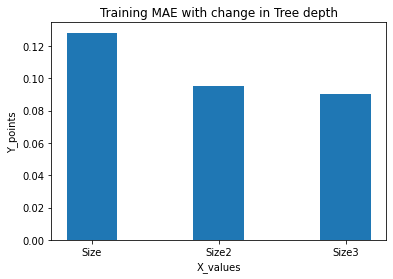

In [133]:
X = [MAE1,MAE2, MAE3]
Y = ['Size','Size2','Size3']
plt.bar(Y,X, 0.4)
plt.title('Training MAE with change in Tree depth')
plt.xlabel('X_values')
plt.ylabel("Y_points")
plt.show();

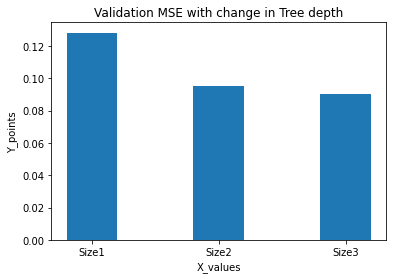

In [134]:
Z =  [MAE1_Test,MAE2_Test, MAE3_Test]
Y = ['Size1','Size2','Size3']
plt.bar(Y,X, 0.4)
plt.title('Validation MSE with change in Tree depth')
plt.xlabel('X_values')
plt.ylabel("Y_points")
plt.show();

As can be observed from the above graphs, with the increase in size of tree, the testing error and validation error reduce significantly. After increasing the size of the trees from 1 to 2, there is not much change in the error metrics.